# Classifying Intonation of QMUL Students' Voices: 
## Bored? Excited? Neutral? Question?

*student name, student ID*:  Callum Ball, 200883652 

---

*Brief summary*: A basic solution currently using only the pitch features provided in the starter kit.

*Dataset preparation*: Load wav files into drive with accompanying dataset describing details of each file; its ID, digit label, participant ID, and intonation class.

*Dataset visualisation*: wave visuals and spectrogram. Use of confusion matrix as the basic visual of classification success. As well as ROC curves and visualising accuracy and loss over epochs with NN.


*Preprocessing*:  extraction of 4 features initially: power, pitch_mean,pitch_std, voiced_fr with normalisation. Then extraction of spectrograms using STFT.

*Model(s) description:*  basic SVM and NB classifiers, not yet optimised, then a MLP, and finally a CNN with dropout and .

*Training and validation tasks*: include splitting traing and validation dataset, which would then be used to optomised the SVC for example. 

*Performance evaluation (accuracy, confusion matrix, ROC curve, etc)*: accuracy and confusion matrix presented. ROC curve and any other relevant evaluation metrics.

*Conclusions.*
CNN's are very powerful and once an SVM is working okay are a great model to try with audio and/or visual data. Optomisation and fine-tuning would likely help. So would more expereimentation along with more data most probably.

reference: https://towardsdatascience.com/speech-classification-using-neural-networks-the-basics-e5b08d6928b7

# Basic Solution

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

import tensorflow as tf
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten
from keras import Input, Model

Mounted at /content/drive


## Data Prep 1

In [2]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [64]:
n=0
fs = None  # # Sampling frequency. If None, fs would be 22050 # change to 16,000 and integrate other dataset?
wav, fs = librosa.load(files[n],sr=fs)
print('sampling rate:', fs, 'samples')
print('wav shape:', wav.shape)
print ('length:', wav.shape[0]/float(fs), 'secs')

sampling rate: 22050 samples
wav shape: (35584,)
length: 1.6137868480725623 secs


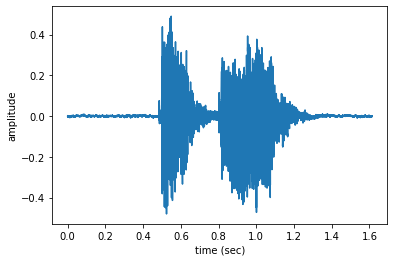

In [65]:
t = np.arange(len(wav))/fs
plt.plot(t, wav)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [66]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0015917.wav'

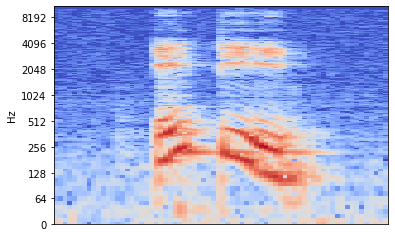

In [67]:
from librosa.display import specshow
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)))  # , ref=np.max
specshow(D, y_axis='log')  # using a log y-axis allows us to see more clerly the low frequency bands more clearly


using a log y-axis allows us to see the low frequency bands more clearly.

listening to the recording we can hear a male voice in an excited intonation, and viewing the spectrogram we see the low-frequencies of a male voice represented along with the more spread out, and less frequent higher pitches of an excited tone. (Will this really work for all signals?)

In [68]:
D.shape

(1025, 70)

librosa.stft Computes the Short Time Fourier Transform for us. The return values is a matrix where X is the window numbers and Y are the frequencies. STFT values are complex numbers. We need use only the real part of it to find the frequency coefficients.
np.abs Takes the absolute of the stft in case of complex number it returns the absolute of the real part.
librosa.amplitude_to_db Converts the values to Decibels.

Fourier Transform — The process of transforming a time-amplitude signal into a frequency-amplitude function
Discrete Fourier Transform (DST) — Fourier Transform discrete signal
Fast Fourier Transform (FFT)— An algorithm that is able to compute the Fourier Transform in O(nlogn) instead of O(n²)
Short-time Fourier transform (STFT) — Algorithm that breaks the recording into small windows and computes DST for each window

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [37]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files, position=0, leave=True):         # for file in files:  # , position=0, leave=True (issue with this method?)
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    
    #fs = None # if None, fs would be 22050
    #x, fs = librosa.load(file,sr=fs)
    #if scale_audio: x = x/np.max(np.abs(x))
    #f0, voiced_flag = getPitch(x,fs,winLen=0.02)
    
    #power = np.sum(x**2)/len(x)
    #pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    #pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    #voiced_fr = np.mean(voiced_flag)

    #xi = [power,pitch_mean,pitch_std,voiced_fr]
    #X.append(xi) 
    y.append(yi)
  return  np.array(y)  # np.array(X),

In [38]:
needXy = True
if needXy:
    y_str = getXy(files[:],labels_file=labels,scale_audio=True)

100%|██████████| 20000/20000 [00:43<00:00, 457.17it/s]


In [42]:
print(y_str[:7])

['excited' 'bored' 'excited' 'neutral' 'neutral' 'excited' 'question']


In [41]:
print(y[:10])

[1 0 1 2 2 1 3 1 1 1]


In [39]:
X = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/X4.csv', sep=' ', header=None)
y = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/y4.csv', header=None)

X = np.array(X)
y = np.array(y)
y = np.ravel(y)

In [20]:
y.shape

(20000,)

## Basic model: SVM and GaussianNB 

In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X,y_str,test_size=0.10)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15)

In [23]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4722352941176471
Validation  Accuracy 0.46066666666666667


In [53]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4699346405228758
Validation  Accuracy 0.4651851851851852


In [24]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5899411764705882
Validation  Accuracy 0.5583333333333333


We see here using the features power, pitch mean, pitch std (?) and voiced fr (?) with a train/dev/test traditional split of 75/15/10 that the SVC model and the Gaussian Naive Bayes perform identically illustrating the often quite similar results of more traditional machine learning approaches.

Consider further how these models could be improved and/or optomised:

Using z-score standardisation normalises the feature values reducing the spread of the dataset's features and hence helps to give more even weighting to values even if they are smaller, e.g. house price vs no. of bedrooms in house. We see a good jump in validation accuracy by almost 10%

Edit: removed the test split to have a train/dev split of 85/15 to match the CNN below.

In [27]:
x = 'neutral'
num_x = len(labels[labels['intonation'] == x])
print("Number of {}'s in our MLEnd dataset:  {}  ".format(x, num_x))

Number of neutral's in our MLEnd dataset:  5000  


The intonation classes are balanced helping to avoid the chance of a model choosing a solution that simply guesses the dominant class and gives higher accuracy than one might imagine without looking deeper.

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_val, yv_p))  # what number does each label correspond to?

class_labels = {0:'bored', 1:'excited', 2:'neutral', 3:'question'}

# discuss classification scores...

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       731
           1       0.60      0.56      0.58       822
           2       0.43      0.43      0.43       715
           3       0.60      0.64      0.62       732

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000



Perhaps unsurprisingly, neutral had the worst f1-score, less than half that of the next worst excited. Why bored and question scored the best using these simple models and selected features is not easy to say. Possibly questions have a specific pitch that is more commonly high likewise with bored which would commonly have a lower pitch. In addition the length of time for question would likely be the shortest and bored the longest. But this is conjecture. 

However, after z-score normalising the differences level off somewhat with bored no longer performing poorly, beating excited f1-score slightly.

In [26]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_heatmap(y_val, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_val))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_val, preds, labels) #, labels
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=15)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

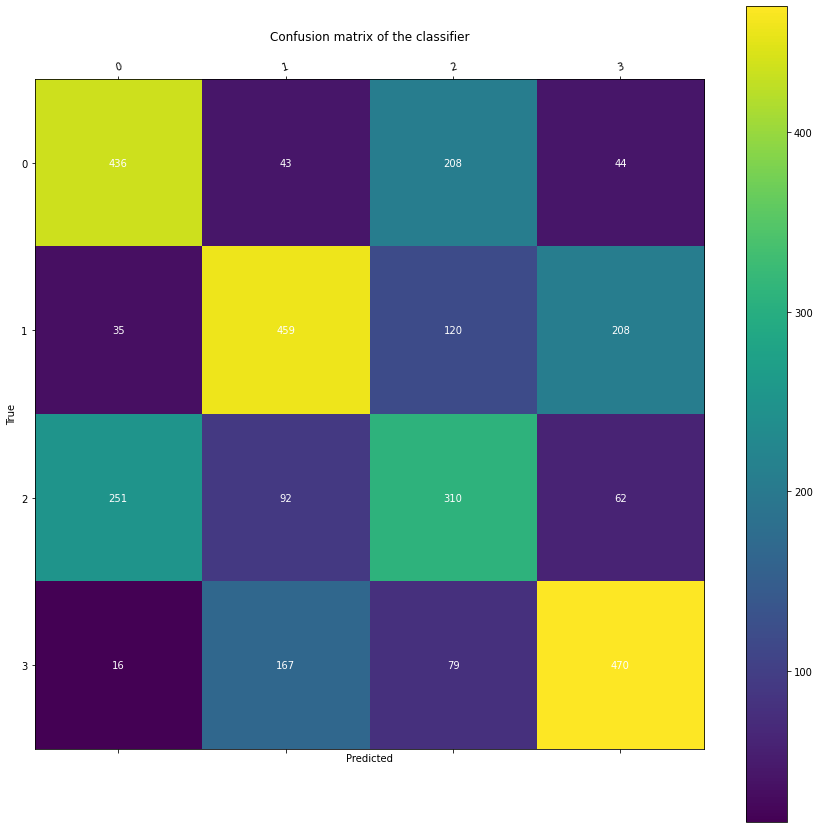

In [27]:
confusion_matrix_heatmap(y_val, yv_p)

Now, checking the confusion matrix we can see that neutral is often mistakenly classified as bored. In fact, of the 725 neutral samples in the classification dataset 482 were classified as bored, compared to 110 as neutral. Maybe the people recording had become bored of it slightly hence the overlap?

Adding normalisation imporves things though the model still struggles differentiating between bored and neutral/

In [58]:
# SVC is binary so re-run SVC with probability=true
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

y = label_binarize(y, classes=['bored','excited','neutral','question'])
n_classes = y.shape[1]

#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


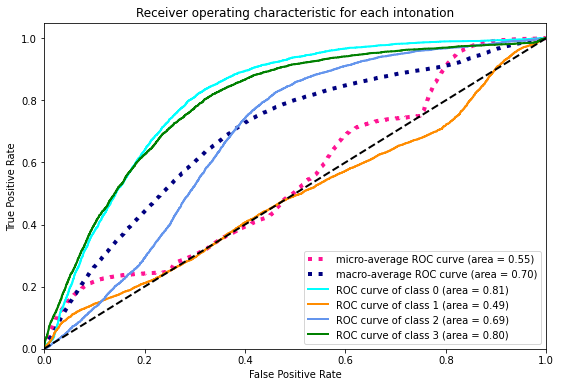

In [62]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(9,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for each intonation')
plt.legend(loc="lower right")
plt.show()

class_labels = {0:'bored', 1:'excited', 2:'neutral', 3:'question'}

The micro-avg ROC_AUC score is very similar to the validation accuracy score at 55%. When comparing to the macro-average the micro-average is 15% lower, which can be in part explained by the greater support of the 'excited' intonation class in the dataset used to plot the above class (though I thought all X was used for above and the intonation classes are balanced?).

Number of excited's in our MLEnd dataset:  5000  


In [ ]:
pip install plot_keras_history

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from plot_keras_history import plot_history

In [86]:
from sklearn.preprocessing import LabelEncoder


y_isStr = False
if y_isStr:
    le = LabelEncoder()
    y = le.fit_transform(y)
    print('yshape is:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15)

y_train_nn = to_categorical(y_train, num_classes=4)
y_val_nn = to_categorical(y_val, num_classes=4)
y_test_nn = to_categorical(y_test, num_classes=4)
y_train_nn.shape

(15300, 4)

## Basic 3 Layer MLP

In [17]:
model = Sequential()
model.add(Dense(32, input_dim=4, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150
479/479 - 2s - loss: 2.2895 - accuracy: 0.4001 - val_loss: 1.1513 - val_accuracy: 0.4459
Epoch 2/150
479/479 - 1s - loss: 1.1609 - accuracy: 0.4410 - val_loss: 1.1374 - val_accuracy: 0.4604
Epoch 3/150
479/479 - 1s - loss: 1.1515 - accuracy: 0.4425 - val_loss: 1.1025 - val_accuracy: 0.4726
Epoch 4/150
479/479 - 1s - loss: 1.1279 - accuracy: 0.4544 - val_loss: 1.1598 - val_accuracy: 0.4548
Epoch 5/150
479/479 - 1s - loss: 1.1221 - accuracy: 0.4543 - val_loss: 1.0896 - val_accuracy: 0.4856
Epoch 6/150
479/479 - 1s - loss: 1.1246 - accuracy: 0.4517 - val_loss: 1.1512 - val_accuracy: 0.4637
Epoch 7/150
479/479 - 1s - loss: 1.1103 - accuracy: 0.4548 - val_loss: 1.1212 - val_accuracy: 0.4719
Epoch 8/150
479/479 - 1s - loss: 1.1084 - accuracy: 0.4586 - val_loss: 1.1408 - val_accuracy: 0.4067
Epoch 9/150
479/479 - 1s - loss: 1.1089 - accuracy: 0.4537 - val_loss: 1.1090 - val_accuracy: 0.4730
Epoch 10/150
479/479 - 1s - loss: 1.0998 - accuracy: 0.4625 - val_loss: 1.0870 - val_accura

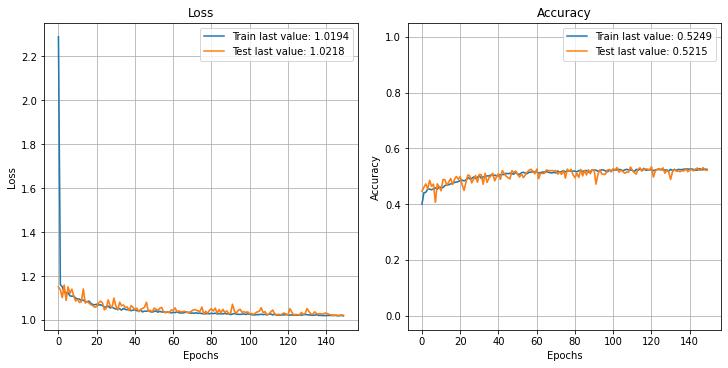

In [89]:
history = model.fit(X_train, y_train_nn, epochs=150, validation_data=(X_val, y_val_nn), verbose=)

plot_history(history.history, path="standard.png")
plt.show()

## New Feature: Short-Time Fourier Transform (STFT) Spectrogram

In [7]:
# code adapted from: https://github.com/shudima/notebooks/blob/master/Speech%20Classification.ipynb

# plus may be best to remake earlier method with tqdm to view progress
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Xno2 = []
spectrograms = []
#mel_spectrograms = []
#mfccs = []
#yno2 = []

#test_X = []
#test_spectrograms = []
#test_mel_spectrograms = []
#test_mfccs = []
#test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

# using wav in place of x
for file in tqdm(files[:], position=0, leave=True):
    try:
        if '.wav' not in file:  # or 'dima' in fname
            continue
        fileID = file.split('/')[-1]
        #digit = list(labels[labels['File ID']==fileID]['digit_label'])[0]
        #speaker = list(labels[labels['File ID']==fileID]['participant'])[0]
        #yi = list(labels[labels['File ID']==fileID]['intonation'])[0]
        wav, sr = librosa.load(file)
        #padded_x = pad1d(wav, 36000)  # are we padding the number of samples? Yes, sample n is 35000 maybe pad to 38000
        spectrogram = np.abs(librosa.stft(wav))
        padded_spectrogram = pad2d(spectrogram,40)  # why pad to 40?

        #mel_spectrogram = librosa.feature.melspectrogram(wav)
        #padded_mel_spectrogram = pad2d(mel_spectrogram,40)

        #mfcc = librosa.feature.mfcc(wav)
        #padded_mfcc = pad2d(mfcc,40)

        #if speaker == test_speaker:
        #    test_X.append(padded_x)
        #    test_spectrograms.append(padded_spectogram)
        #    test_mel_spectrograms.append(padded_mel_spectrogram)
        #    test_mfccs.append(padded_mfcc)
        #    test_y.append(digit)

        #Xno2.append(padded_x)
        spectrograms.append(padded_spectrogram)
        #mel_spectrograms.append(padded_mel_spectrogram)
        #mfccs.append(padded_mfcc)
        #yno2.append(yi)
    except Exception as e:
        print(file, e)
        #raise

#Xno2 = np.vstack(Xno2)
spectrograms = np.array(spectrograms)
#mel_spectrograms = np.array(mel_spectrograms)
#mfccs = np.array(mfccs)
#le = LabelEncoder()
#yno2 = le.fit_transform(yno2)
#yno2 = to_categorical(np.array(yno2), num_classes=4)


#test_X = np.vstack(test_X)
#test_spectrograms = np.array(test_spectrograms)
#test_mfccs = np.array(test_mfccs)
#test_mel_spectrograms = np.array(test_mel_spectrograms)
#test_y = to_categorical(np.array(test_y))

print('\n')
#print('Xno2:', Xno2.shape)
print('spectrograms:', spectrograms.shape)
#print('mel_spectrograms:', mel_spectrograms.shape)
#print('mfccs:', mfccs.shape)
#print('yno2:', yno2.shape)


100%|██████████| 20000/20000 [02:08<00:00, 155.88it/s]




spectrograms: (20000, 1025, 40)


In [ ]:
save_spec = False

In [8]:
# save the spectrograms to the drive
if save_spec:
    import numpy as np
    np.save('spectrograms', spectrograms)

In [9]:
spectrograms = np.load('/content/drive/MyDrive/Data/MLEnd/spectrograms.npy')

In [ ]:
scale_save = False

In [ ]:

if scaled_save:
    def scale_minmax(X, min=0.0, max=1.0):
        X_std = (X - X.min()) / (X.max() - X.min())
        X_scaled = X_std * (max - min) + min
        return X_scaled

    def save_spect(spectrograms)  # should I use normalisation of spectrograms in my CNN?
        img = scale_minmax(spectograms, 0, 255).astype(numpy.uint8)
        img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
        img = 255-img # invert. make black==more energy

        # save as PNG
        import scipy.misc
        scipy.misc.imsave('spec-librosa.png', mfccs)

In [11]:
 from sklearn.model_selection import train_test_split

train_spectrograms, test_spectrograms, y_train2, y_test2 = train_test_split(spectrograms, y[:], test_size=0.15)

# split train into train-dev
y_train2= to_categorical(y_train2, num_classes=4)
y_test2= to_categorical(y_test2, num_classes=4)
y_train2.shape

(17000, 4)

## CNN with dropout (adding complexity and parameters)

In [12]:
train_spectrograms[0].shape

(1025, 40)

In [13]:
train_X_ex = np.expand_dims(train_spectrograms, -1)
test_X_ex = np.expand_dims(test_spectrograms, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (17000, 1025, 40, 1)
test X shape: (3000, 1025, 40, 1)


In [14]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(4, activation='softmax')(m)

model = Model(inputs=ip, outputs=op)

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1025, 40, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1022, 37, 64)      1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 9, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 255, 9, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 146880)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4700192   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132   

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          y_train2,
          epochs=10,  # maybe reduce the number of epochs?
          batch_size=32,  # change the batch size?
          verbose=1,
          validation_data=(test_X_ex, y_test2))  # should use validation data rather than test data...
          # add early stopping
          #callbacks=[earlystopping_cb, mdlcheckpoint_cb])


Epoch 1/10
532/532 [==============================] - 258s 482ms/step - loss: 1.4223 - accuracy: 0.5095 - val_loss: 0.9213 - val_accuracy: 0.6060
Epoch 2/10
532/532 [==============================] - 251s 472ms/step - loss: 0.8098 - accuracy: 0.6642 - val_loss: 0.8832 - val_accuracy: 0.6393
Epoch 3/10
532/532 [==============================] - 250s 470ms/step - loss: 0.6808 - accuracy: 0.7202 - val_loss: 0.8753 - val_accuracy: 0.6620
Epoch 4/10
532/532 [==============================] - 251s 472ms/step - loss: 0.5886 - accuracy: 0.7630 - val_loss: 0.9103 - val_accuracy: 0.6677
Epoch 5/10
532/532 [==============================] - 251s 472ms/step - loss: 0.5166 - accuracy: 0.7947 - val_loss: 0.9473 - val_accuracy: 0.6633
Epoch 6/10
532/532 [==============================] - 249s 469ms/step - loss: 0.4417 - accuracy: 0.8265 - val_loss: 1.0280 - val_accuracy: 0.6687
Epoch 7/10
532/532 [==============================] - 248s 466ms/step - loss: 0.3892 - accuracy: 0.8497 - val_loss: 1.0847 -

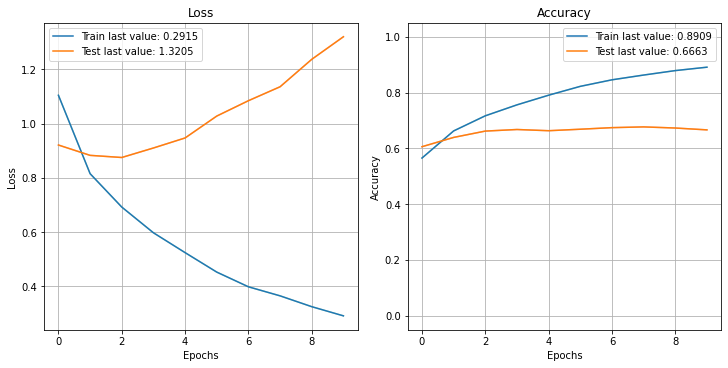

In [16]:
plot_history(history.history, path="standard.png")
plt.show()

We can see that by the the third epoch the CNN has almost reached peak performance at just over 66% validation accuracy. Hence adding early stopping would avoid the wasted computation time where the validation loss is increasing and the validation accuracy has plateaued.

How can I reduce the size of this model? Do I need to prune etc.?

The CNN has many more parameters and required a lot longer to train than the SVC, but managed to acheive just over a 10% improved accuracy.